In [95]:
import os
import numpy as np 
import pandas as pd
from PIL import Image
from sklearn.metrics import confusion_matrix
import cv2
from skimage.filters import frangi, hessian
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras
from keras import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
import warnings
warnings.filterwarnings("ignore")

In [96]:
os.chdir('/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images')
dir_names=["Mild", "Moderate", "No_DR", "Proliferate_DR", "Severe"]

In [97]:
images=[]
labels=[]

In [155]:
for dir in dir_names:
    os.chdir('./'+dir)
    imgs_names=os.listdir()
    for img_name in imgs_names:
        with Image.open(img_name) as image:
            image=np.array(image)
            images.append(image)
            label = "No_DR" if dir == "No_DR" else "DR"
            labels.append(label)
    os.chdir('../')

In [ ]:
import seaborn as sns

In [ ]:
sns.countplot(x=labels)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
images = np.array(images)
labels = np.array(labels)

# Shuffle the data
indices = np.arange(len(images))
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]

DR


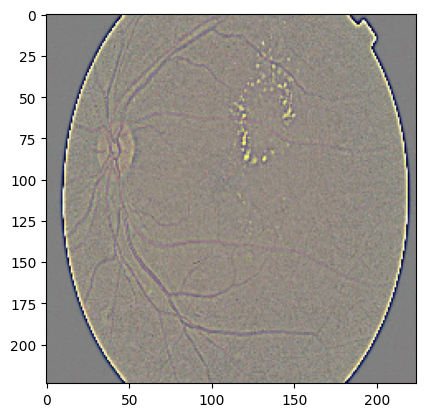

In [156]:
plt.imshow(images[55])
print(labels[0])

In [157]:
images[0].shape

(224, 224, 3)

In [ ]:

def preprocessing(image, scale_range=(1, 10), scale_step=2, beta=0.5):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Frangi filter to enhance vessel-like structures
    frangi_image = frangi(gray_image, scale_range=scale_range, scale_step=scale_step, beta=beta)

    # Normalize the Frangi-filtered image to [0, 255]
    frangi_image = cv2.normalize(frangi_image, None, 0, 1, cv2.NORM_MINMAX)

    return frangi_image

DR


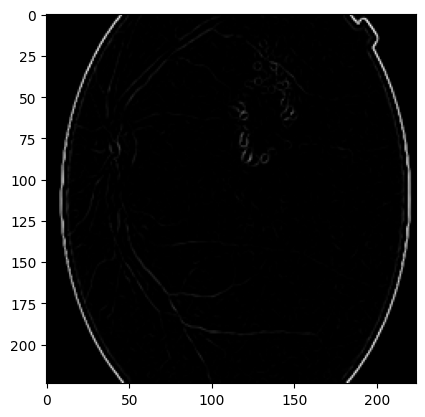

In [158]:
preprocessed_image=preprocessing(images[55])
plt.imshow(preprocessed_image,cmap='gray')
print(labels[55])

In [ ]:
preprocessed_images=np.array([preprocessing(img) for img in images])

In [ ]:
def threshold_image(image):
    mean_intensity = np.mean(image)
    thresholded_image = np.where(image > mean_intensity, 1, 0)
    return thresholded_image

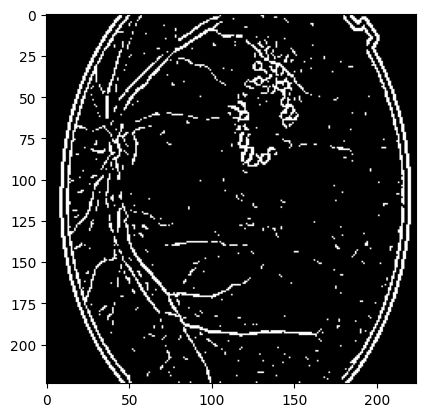

In [159]:
plt.imshow(threshold_image(preprocessed_image),cmap='gray')

In [ ]:
thresholded_images=np.array([threshold_image(img) for img in preprocessed_images])

In [ ]:
plt.imshow(thresholded_images[55],cmap='gray')

In [ ]:
encoder=LabelEncoder()
labels=encoder.fit_transform(labels)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(thresholded_images,labels,test_size=.2,random_state=404,stratify=labels)

In [160]:


model = Sequential([
    Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(224, 224,1), padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    Dropout(0.5),
    Flatten(),
    Dense(120, activation='relu'),
    Dropout(0.5),
    Dense(84, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Using sigmoid activation for binary classification
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [161]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [162]:
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 224, 224, 6)    │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 112, 112, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 108, 108, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 120)            │     5,598,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,611,661 (21.41 MB)

 Trainable params: 5,611,661 (21.41 MB)

 Non-trainable params: 0 (0.00 B)

In [163]:
history = model.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_test, y_test), callbacks=[early_stopping],shuffle=True)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 356ms/step - accuracy: 0.6099 - loss: 0.8324 - val_accuracy: 0.8568 - val_loss: 0.3617
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8653 - loss: 0.3591 - val_accuracy: 0.8895 - val_loss: 0.2454
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9177 - loss: 0.2411 - val_accuracy: 0.8895 - val_loss: 0.2413
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9382 - loss: 0.2024 - val_accuracy: 0.9154 - val_loss: 0.2163
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9360 - loss: 0.2030 - val_accuracy: 0.9181 - val_loss: 0.2156
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9459 - loss: 0.1798 - val_accuracy: 0.9209 - val_loss: 0.2237
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9539 - loss: 0.1399 - val_accuracy: 0.9236 - val_loss: 0.2174


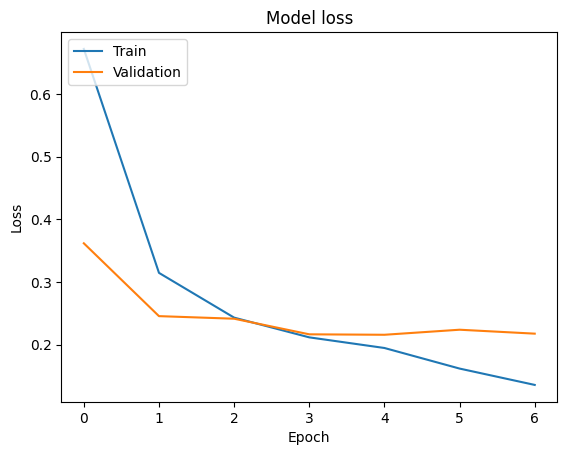

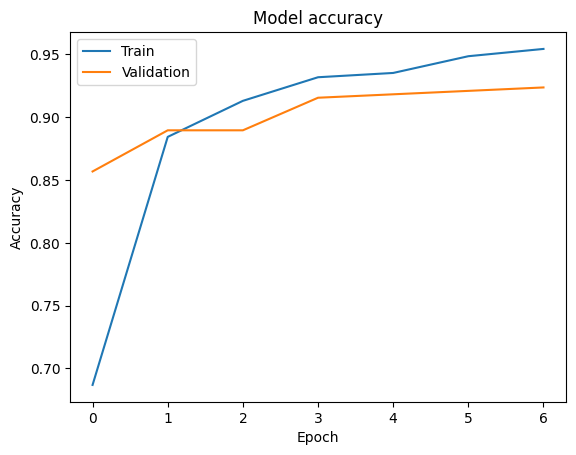

In [164]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Confusion Matrix:
Axes(0.125,0.11;0.62x0.77)


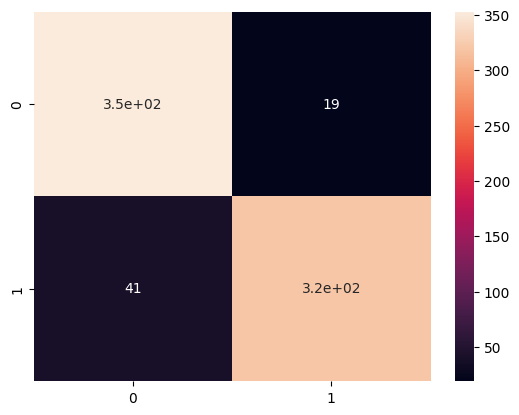

In [165]:
y_pred_probs = model.predict(x_test)
y_pred = np.where(y_pred_probs > 0.5, 1, 0)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(sns.heatmap(conf_matrix,annot=True))

In [154]:
model.save('/kaggle/working/binary_classifier.h5')